# Parametric Survival Anlaysis

### Introduction

As we learned in the non-parametric analysis, sometimes we need to extrapolate or interpolate estimations of reliability. Non-parametric models are not always suited to this. As such we need another method to model reliability.

Before diving explicity into the distribution most commonly used in survival analysis, we will dive into an experiment. In this experiment we are going to find the strength of a chain.

It is quite obvious that the strength of a chain to bear a load is equal to the strength of the weakest link. This is true of many other scenarios, the strength of cotton fibres is only as much as the weakest strand in the fibre, survival times, strength of structures. All these depend on the minimum strength to determine the strength/duration of the object/person. Any way to model this behaviour would be extremely (hint) useful.

Let's start with a chain. Let's say we are trying to estimate the strength of a chain for some application. We have 100 test chains. Each chain has 1000 links, the distribution of chain link strength is normal with mean 200 and std dev of 10. Some simple monte carlo modelling can show us what we might expect:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [217]:
n = 1000
mean = 200
std_dev = 10
links = 1000

chain_strength = np.random.normal(mean, std_dev, size=(n, links)).min(axis=0)

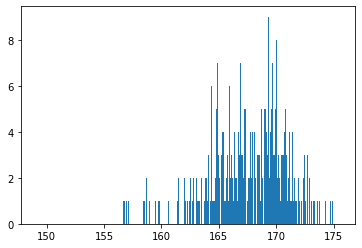

In [218]:
plt.hist(chain_strength, bins=n);

That seems to be quite regularly distributed. What happens if we increase the number of links and the count of chains?


In [219]:
links = 100000
chain_strength = np.random.normal(loc=mean, scale=std_dev, size=(n, links)).min(axis=0)

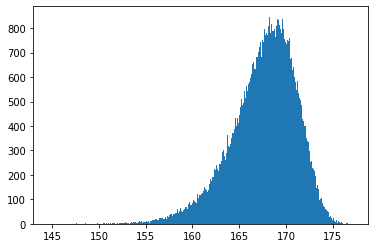

In [220]:
plt.hist(chain_strength, bins=int(n/2));

This appears to be quite a regular distribution. If we get some information about this distribution we could know a lot about the strength of these chains.

It turns out, that as the number of chains and links tend to infinity, the distribution converges to the 'Weibull' distribution. This is exactly analagous to the central limit theorem and the normal distribution. That is, as we get more and more samples, the mean of a set of random variables converges to the normal distribution. Whereas here we have shown that that the minimum converges to a Weibull distribution. Neat huh!

But what is the weibull distribution?

$$ F = 1 - e^{-({\frac{x}{\alpha}})^\beta}  $$

The above equation is the CDF for the Weibull distribution. For survival analysis, F is the probability of not surviving till x. Or put another way, it is the probability of dying (failing) before reaching x.

For the equation above, x is the variable, alpha is the 'characteristic life' or scale parameter, and beta is the shape parameter.

Let's use surpyval to fit a distribution.

In [221]:
import surpyval as surv

In [222]:
x = chain_strength

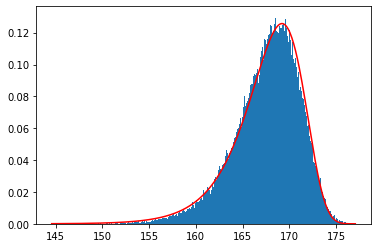

In [223]:
model = surv.parametric.Gumbel.fit(x, how="MLE")
xx = np.arange(np.min(x), np.max(x), 0.1)
y = model.df(xx)
plt.hist(x, density=True, bins=int(n/2))
plt.plot(xx, y, color='r');
model.params;

The above plot shows our parametric distribution fits our simulated data remarkably well. It also turns out the Weibull distribution is one of three distributions as part of 'Extreme Value' statistics. The other distributions are the Gumbel and the Frechet (where the Frechet distribution models the maxmimum!). But this is not important for our survival analysis. 

The important fact for us is that the Weibull distribution is useful for modeling the strength (or reliability) in many different scenarios.

### Finding Weibull Parameters

The question now is, how do we find the parameters for the Weibull distribution?

The SurPyval package allows users to use several methods, these are:
- Plotting Positions
- Method of Moments
- [Maximum Likelihood](MLE%20Visualisation.ipynb) 
- Maximum Spacing Estimation

The examples used for these will be for complete data.

/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


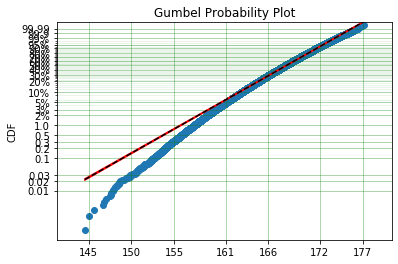

In [755]:
a = model.plot()

In [127]:
def turnbull(l, u):
    taus = np.sort(np.unique(np.concatenate([l, u])))
    m = len(taus) - 1
    n = len(l)
    p = np.ones(m)/m
    alphas = np.zeros((n, m))
    for j in range(m):
        tau = taus[j]
        alphas[:, j] = (((l < tau) & (tau <= u)) | ((l == tau) & (tau == u)))
    d = np.zeros(m)
    for i in range(3):
        for j in range(m):
            a = alphas[:, j] * p[j]
            for i in range(n):
                denom = (alphas[i, :] * p).sum()
                a[i] = a[i]/denom
            a[np.isnan(a)] = 0
            d[j] = a.sum()
        r = np.hstack([[n], n - d.cumsum()])[:-1]
        p = np.cumprod(1 - d/r)
        p = np.abs(np.diff(np.hstack([[1], p])))
    f ="""
    for i in range(0):
        denom = (alphas.reshape((*alphas.shape, 1)) * p).sum(axis=1)
        d = ((alphas * p)/denom).sum(axis=0)
        r = np.hstack([[n], n - d.cumsum()])[:-1]
        p = np.cumprod(1 - d/r)
        p = np.abs(np.diff(np.hstack([[1], p])))
    """
    return alphas, p, taus, d, r

In [128]:
lower = np.array([1,  76,  288, 501, 579, 667, 829, 920, 1071])
upper = np.array([71, 169, 344, 504, 579, 754, 829, 971, np.inf])
#n = len(lower)
#m = len(tau) - 1

In [134]:
low = np.array([0, 0, 0, 4, 5, 5, 6, 7, 7, 11, 11, 15, 17, 17, 
                17, 18, 19, 18, 22, 24, 24, 25, 26, 27, 32, 33, 
                34, 36, 36, 36, 36, 37, 37, 37, 37, 38, 40, 45, 
                46, 46, 46, 46, 46, 46, 46, 46])
upp = np.array([7, 8, 5, 11, 12, 11, 10, 16, 14, 15, 18, np.inf, 
                np.inf, 25, 25, np.inf, 35, 26, np.inf, np.inf, 
                np.inf, 37, 40, 34, np.inf, np.inf, np.inf, 44, 
                48, np.inf, np.inf, 44, np.inf, np.inf, np.inf, 
                np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 
                np.inf, np.inf, np.inf, np.inf, np.inf])

In [135]:
a, p, tau, d, r = turnbull(low, upp)

In [145]:
(a * p).sum(axis=0)

array([0.00000000e+00, 4.93117444e-02, 1.03776562e-01, 7.76173087e-02,
       2.04024318e-01, 3.06808384e-01, 1.66393362e-01, 5.93283540e-02,
       1.47681312e-01, 7.58805417e-02, 2.93826430e-02, 5.12611938e-03,
       9.10923859e-04, 5.07716545e-02, 6.73634488e-02, 1.20389333e-01,
       1.57031556e-01, 2.53767467e-01, 7.47979046e-02, 4.03858643e-02,
       1.69286144e-01, 2.19150229e-01, 2.81540165e-01, 1.10911190e-01,
       5.82286359e-02, 2.97065132e-01, 6.98936320e-01, 8.88191249e-01,
       8.57433738e-01, 2.95478291e-01, 4.76716985e-01, 1.03633678e+01])

In [146]:
d

array([ 0.        ,  0.75611341,  1.19343046,  0.71407924,  1.56418644,
        2.01616938,  1.27568244,  0.54582086,  1.35866807,  0.87262623,
        0.45053386,  0.0786005 ,  0.02095125,  0.46709922,  0.51645311,
        0.7911299 ,  0.90293144,  1.16733035,  0.3823004 ,  0.20641664,
        0.77871626,  0.91644641,  1.0792373 ,  0.42515956,  0.24350157,
        0.91099974,  1.7861706 ,  2.15035776,  2.07589221,  0.79952949,
        1.21827674, 18.33518916])

In [132]:
R = np.cumprod(1 - (d/r))

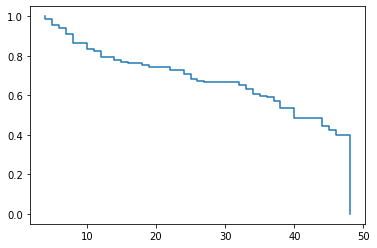

In [133]:
plt.step(tau[1::], R)

In [118]:
R

array([1.        , 0.88888889, 0.88888889, 0.77777778, 0.77777778,
       0.66666667, 0.66666667, 0.55555556, 0.44444444, 0.44444444,
       0.33333333, 0.22222222, 0.22222222, 0.11111111, 0.11111111])